# Applied Time Series – December 2025

## Exercise 6 – Volatility is (Mostly) Path Dependent





In [16]:
%pip install yfinance

Note: you may need to restart the kernel to use updated packages.


### 6.1 Data loading and preprocessing

In [17]:
import pandas as pd
import yfinance as yf

load_from = pd.to_datetime("2006-01-01")
train_start_date = pd.to_datetime("2011-01-01")
test_start_date = pd.to_datetime("2019-01-01")
test_end_date = pd.to_datetime("2022-05-15")

msft = yf.Ticker("MSFT").history(start=load_from, end=test_end_date)["Close"]
vix  = yf.Ticker("^VIX").history(start=load_from, end=test_end_date)["Close"]

msft.index = pd.to_datetime(msft.index).tz_localize(None)
vix.index  = pd.to_datetime(vix.index).tz_localize(None)

common = msft.index.intersection(vix.index)
msft = msft.loc[common]
vol_proxy = (vix.loc[common] / 100)  


### 6.2 Empirical calibration and out-of-sample validation

Using the repository implementation (perform_empirical_study), we calibrate the linear PDV model on a predefined training window by estimating the optimal model parameters. The calibrated model is then used to generate predicted volatility on an out-of-sample test window, allowing us to assess its explanatory and predictive performance using standard metrics such as R^2 and RMSE.


In [18]:

from empirical_study.main_function import perform_empirical_study

sol = perform_empirical_study(
    vol=vol_proxy,
    index=msft,
    p=1,
    setting=[(1,1), (2,1/2)],   
    tspl=False,
    train_start_date=train_start_date,
    test_start_date=test_start_date,
    test_end_date=test_end_date,
    max_delta=750
)

print("Optimal params:", sol["opt_params"])
print({
    "train_r2": sol["train_r2"],
    "test_r2": sol["test_r2"],
    "train_rmse": float(sol["train_rmse"]),
    "test_rmse": float(sol["test_rmse"])
})

Optimal params: {'beta_0': 0.0875992720583809, 'theta_1': 0.6526991455999165, 'lambda_1': array([171.80161143, 729.746429  ]), 'beta_1': -0.012043550937366395, 'theta_2': 0.994323218805592, 'lambda_2': array([0.18601636, 0.02496657]), 'beta_2': 1.089673808800867}
{'train_r2': 0.24396377867011887, 'test_r2': 0.08649496995675399, 'train_rmse': 0.04818310980619276, 'test_rmse': 0.08843056643556955}


The model returned:

Train R² ≈ 0.244

Test R² ≈ 0.0865

Train RMSE ≈ 0.048

Test RMSE ≈ 0.088

The fitted PDV specification exhibits moderate in-sample explanatory power, with a training R^2 of approximately 0.24, indicating that the model is able to capture a non-negligible fraction of the variability in the volatility proxy during the calibration period. This suggests that the PDV factors do contain economically meaningful information about volatility dynamics.

However, the out-of-sample performance deteriorates substantially, with a test R^2 of approximately 0.09. This sharp decline points to limited predictive power and indicates that only a small fraction of the volatility variability is explained on unseen data. Consistently, the RMSE increases markedly from about 0.048 in-sample to 0.088 out-of-sample, reflecting a significant loss in accuracy when moving from calibration to validation.

In [19]:
%pip install numpy pandas scipy scikit-learn matplotlib arch yfinance


Note: you may need to restart the kernel to use updated packages.


### 6.3 GJR-GARCH benchmark estimation and volatility comparison

In [20]:
import numpy as np
from arch import arch_model

ret = 100 * msft.pct_change().dropna()

gjr = arch_model(
    ret,
    mean="Zero",
    vol="GARCH",
    p=1, o=1, q=1,
    dist="skewt"
)
gjr_res = gjr.fit(disp="off")

gjr_sigma = pd.Series(gjr_res.conditional_volatility, index=ret.index)

gjr_vol_annual = gjr_sigma * np.sqrt(252) / 100  

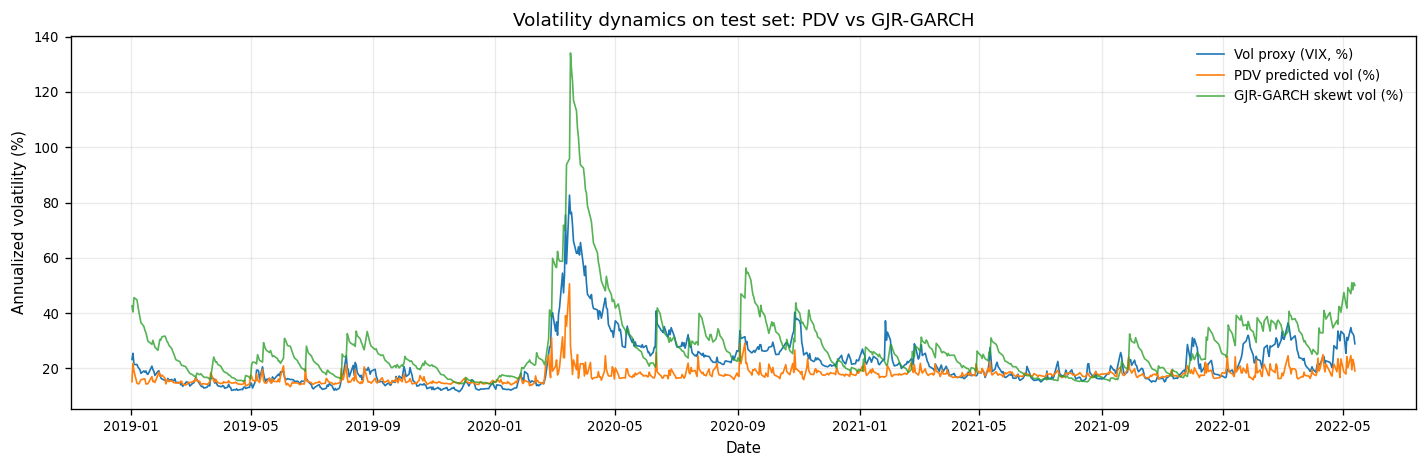

In [27]:
import matplotlib.pyplot as plt

pred_test = sol["test_pred"]  

idx = pred_test.index.intersection(gjr_vol_annual.index)

pdv_test = pred_test.loc[idx]
gjr_test = gjr_vol_annual.loc[idx]
vix_test = vol_proxy.loc[idx]

plt.figure(figsize=(12,4))
plt.plot(vix_test.index, 100*vix_test, label="Vol proxy (VIX, %)")
plt.plot(pdv_test.index, 100*pdv_test, label="PDV predicted vol (%)")
plt.plot(gjr_test.index, 100*gjr_test, label="GJR-GARCH skewt vol (%)", alpha=0.8)
plt.title("Volatility dynamics on test set: PDV vs GJR-GARCH", fontsize=11)
plt.ylabel("Annualized volatility (%)", fontsize=9)
plt.xlabel("Date", fontsize=9)
plt.legend(fontsize=8,frameon=False)
plt.tick_params(axis="both", labelsize=8)
plt.grid(True, alpha=0.25)
plt.tight_layout()
plt.show()

### Conclusion
The GJR–GARCH model generates volatility spikes that are substantially higher than both the PDV predictions and the VIX-based volatility proxy, particularly during stress episodes. In contrast, the PDV-predicted volatility is noticeably smoother and captures the broad level and medium-term dynamics of the volatility proxy without exhibiting extreme overshoots. Visually, the PDV model remains closer to the VIX proxy for most of the test period, whereas the GJR–GARCH specification produces pronounced but short-lived volatility bursts.

### 6.4 Monte Carlo pricing under the Markovian PDV model: vanilla prices and implied volatility smile

As-of date: 2022-05-13 00:00:00
Forward (normalized): 1.0004433393478394


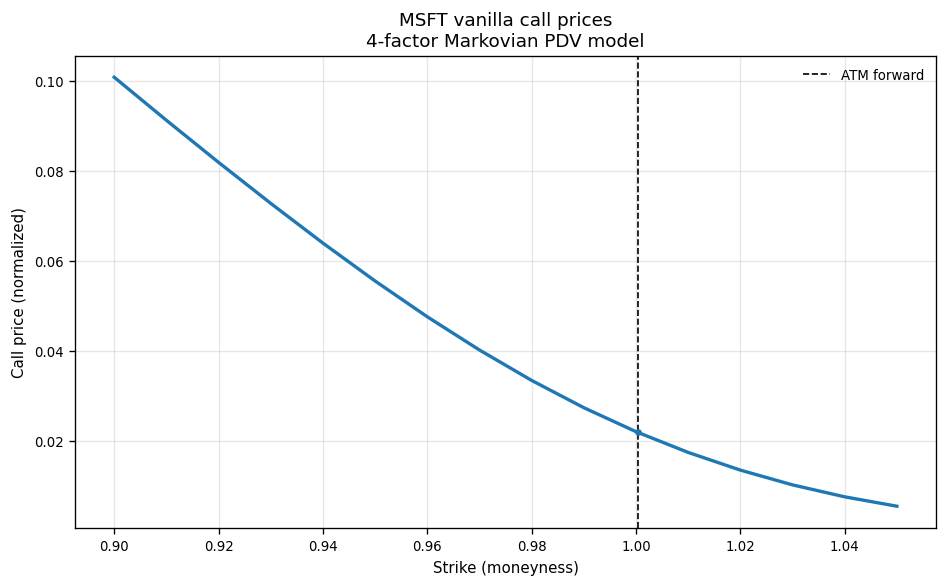

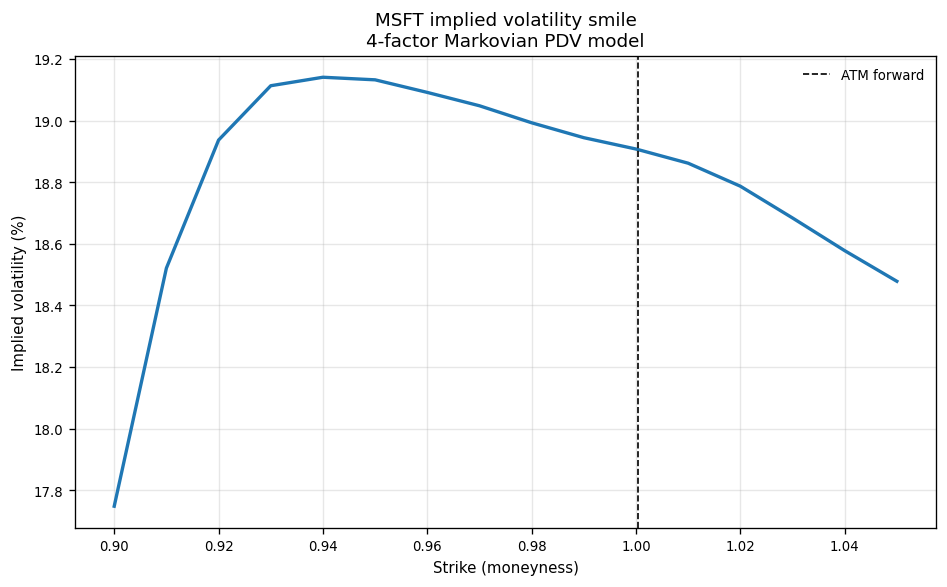

In [28]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

from calibration.torch_montecarlo import (
    TorchMonteCarloExponentialModel,
    initialize_R,
    identity,
    squared
)

asofdate = msft.index.max()                      
load_from_mc = asofdate - pd.Timedelta(days=4*365)

msft_hist = msft.loc[load_from_mc:asofdate].copy()
msft_hist.index = pd.to_datetime(msft_hist.index).tz_localize(None)
msft_hist = msft_hist.sort_index()

p = sol["opt_params"]

lam1 = torch.tensor(np.array(p["lambda_1"], dtype=float), dtype=torch.float32)
lam2 = torch.tensor(np.array(p["lambda_2"], dtype=float), dtype=torch.float32)

betas = torch.tensor(
    [float(p["beta_0"]), float(p["beta_1"]), float(p["beta_2"])],
    dtype=torch.float32
)

theta1 = float(p["theta_1"])
theta2 = float(p["theta_2"])


parabolic = 0.0
parabolic_offset = 0.0


R_init1 = initialize_R(lam1, past_prices=msft_hist, transform=identity)
R_init2 = initialize_R(lam2, past_prices=msft_hist, transform=squared)

N = 20000
vix_N = 1000             
maturity = 0.25
timestep_per_day = 5             

torch_mc = TorchMonteCarloExponentialModel(
    lam1=lam1, lam2=lam2,
    betas=betas,
    R_init1=R_init1, R_init2=R_init2,
    theta1=theta1, theta2=theta2,
    N=N, vix_N=vix_N,
    maturity=maturity,
    parabolic=parabolic,
    parabolic_offset=parabolic_offset,
    timestep_per_day=timestep_per_day,
    device="cpu"           
)
torch_mc.simulate()

option_maturity = 1/12   
strikes = np.arange(0.9, 1.05, 0.01)   

future, _, implied_vol, option_prices = torch_mc.compute_implied_vol(
    strikes=strikes,
    option_maturity=option_maturity,
    volatility=False,
    var_reduction=True
)

future_val = float(future)

print("As-of date:", asofdate)
print("Forward (normalized):", float(future))

plt.figure(figsize=(8,5))
plt.plot(strikes, option_prices, lw=2)
plt.axvline(x=future_val, linestyle="--", color="k", label="ATM forward")

atm_idx = np.argmin(np.abs(strikes - future_val))
plt.scatter([future_val], [option_prices[atm_idx]], zorder=3)

plt.title("MSFT vanilla call prices\n4-factor Markovian PDV model", fontsize=11)
plt.xlabel("Strike (moneyness)", fontsize=9)
plt.ylabel("Call price (normalized)", fontsize=9)
plt.grid(alpha=0.3)
plt.legend(fontsize=8, frameon=False)
plt.tick_params(axis="both", labelsize=8)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,5))
plt.plot(strikes, implied_vol * 100, lw=2)   
plt.axvline(x=future_val, linestyle="--", color="k", label="ATM forward")

plt.title("MSFT implied volatility smile\n4-factor Markovian PDV model", fontsize=11)
plt.xlabel("Strike (moneyness)", fontsize=9)
plt.ylabel("Implied volatility (%)", fontsize=9)
plt.grid(alpha=0.3)
plt.legend(fontsize=8, frameon=False)
plt.tick_params(axis="both", labelsize=8)
plt.tight_layout()
plt.show()


### Conclusion 

Using the calibrated PDV parameters within the 4-factor Markovian PDV framework, we price vanilla call options via Monte Carlo simulation. The resulting option prices are arbitrage-free and give rise to a non-flat implied volatility smile. This demonstrates that the path-dependent volatility structure embedded in the PDV model is sufficient to generate non-trivial implied volatility patterns, even in the absence of additional features such as jumps or stochastic interest rates.